In [126]:
import os
import omdb
import csv
import pickle
import math
import collections
import pandas as pd
print(pd.__version__)
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from networkx.algorithms import clique
from networkx.algorithms import cluster
from networkx.algorithms import link_prediction
from networkx.algorithms import shortest_paths
from scipy.optimize import curve_fit
print(nx.__version__)
pd.set_option('display.max_columns', None)

import itertools
import sklearn as sk
import sklearn.cluster as cluster
from sklearn import linear_model, decomposition, preprocessing
from sklearn.metrics import confusion_matrix, explained_variance_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

0.19.2
2.0


In [92]:
dfOriginal = pickle.load(open("databasedump.pickle", 'rb'))
df = dfOriginal
#'box_office', 'imdb_rating', 'imdb_votes', 'metascore'
df['imdb_rating'] = df['imdb_rating'].str.replace(',', '')
df['imdb_votes'] = df['imdb_votes'].str.replace(',', '')
df['metascore'] = df['metascore'].str.replace(',', '')
df['box_office'] = df['box_office'].str.replace(',', '')
df['box_office'] = df['box_office'].str.replace('$', '')
df = df.replace("N/A", np.nan)
#df['imdb_rating'] = pd.to_numeric(df['imdb_rating'])
#df['imdb_rating'] = df['imdb_rating'].convert_objects(convert_numeric=True)
#df['year'] = df['year'].convert_objects(convert_numeric=True)

In [93]:
#print(pd.isnull(df).sum())
df = df.dropna(axis=0, how='any', subset=['imdb_rating', 'year', 'box_office'])
#print(pd.isnull(dfNoNA).sum())

In [94]:
df['award_dummy'] = 0

for index, row in df.iterrows():
    awards = row['awards']
    boxOffice = row['box_office']
    #print(movie)
    #print(str(movieDegrees[movie]))
    if isinstance(awards, str):
        df.set_value(index, 'award_dummy', 1)
    else:
        df.set_value(index, 'award_dummy', 0)
        
    if 'k' in boxOffice:
        #print(type(boxOffice))
        boxOffice = boxOffice.replace('k', '')
        #print(boxOffice)
        boxOffice = float(boxOffice)
        boxOffice = boxOffice * 1000
        boxOffice = str(boxOffice)
        print(boxOffice)
        df.set_value(index, 'box_office', boxOffice)

25700.0


In [177]:
df.table()

AttributeError: 'DataFrame' object has no attribute 'table'

In [53]:
df.describe(include = 'all')

,actors,awards,box_office,country,director,genre,imdb_rating,imdb_votes,language,metascore,plot,production,rated,released,title,writer,year,title_director,award_dummy
count,3028,2755,3029,3029,3029,3029,3029,3029,3028,2887,3028,3018,2961,3027,3029,2979,3029,3029,3029.000000
unique,3008,1008,2899,467,1708,339,72,2993,534,94,3024,434,11,1245,3026,2758,57,3029,NaN
top,"Ian McKellen, Martin Freeman, Richard Armitage...",1 nomination.,100000,USA,Steven Soderbergh,"Comedy, Drama, Romance",6.5,5723,English,55,A five year-old boy develops a relationship wi...,Warner Bros. Pictures,R,11 Oct 2002,Ponyo,Woody Allen,2006,Looking for Comedy in the Muslim World: Albert...,NaN
freq,3,228,14,1607,14,169,134,2,1725,71,2,206,1283,8,2,12,234,1,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.909541
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.286885
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [97]:
dfNum = df[['box_office', 'imdb_rating', 'imdb_votes', 'metascore', 'year', 'award_dummy']].copy()
dfNum = dfNum.astype(float)
dfNum['title_director'] = df['title_director']
dfNum.describe(include = 'all')

,box_office,imdb_rating,imdb_votes,metascore,year,award_dummy,title_director
count,3.029000e+03,3029.000000,3.029000e+03,2887.000000,3029.000000,3029.000000,3029
unique,NaN,NaN,NaN,NaN,NaN,NaN,3029
top,NaN,NaN,NaN,NaN,NaN,NaN,Looking for Comedy in the Muslim World: Albert...
freq,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,4.287892e+07,6.469495,9.722144e+04,54.841704,2006.840211,0.909541,NaN
std,7.039966e+07,1.039046,1.505878e+05,17.955098,7.128715,0.286885,NaN
min,4.770000e+02,1.600000,3.400000e+01,1.000000,1918.000000,0.000000,NaN
25%,1.700000e+06,5.900000,1.510300e+04,42.000000,2004.000000,1.000000,NaN
50%,1.624759e+07,6.600000,4.325400e+04,55.000000,2007.000000,1.000000,NaN
75%,5.227748e+07,7.200000,1.116700e+05,68.000000,2011.000000,1.000000,NaN


In [76]:
#process dataframe into network
allActors = []
biGraph = nx.Graph()
actorSet = 0
movieSet = 1
count = 0

for index, row in dfOriginal.iterrows():
    movie = row['title_director']
    biGraph.add_nodes_from([movie], bipartite=movieSet)
    actors = row['actors']
    awards = row['awards']
    if isinstance(actors, str):
        actors = actors.split(', ')
        #print(actors)
        for actor in actors:
            if not any(actor == name for name in allActors): # if actor is not in allActors already:
                allActors.append(actor)
                biGraph.add_nodes_from([actor], bipartite=actorSet)
                biGraph.add_edge(movie, actor, weight=1)
            else:
                biGraph.add_edge(movie, actor, weight=1)
    
    count = count + 1


In [77]:
movieNodes = set(n for n, d in biGraph.nodes(data=True) if d['bipartite']==movieSet)
actorNodes = set(n for n, d in biGraph.nodes(data=True) if d['bipartite']==actorSet)
print(len(movieNodes))
print(len(actorNodes))

15674
27352


In [78]:
for actor in actorNodes:
    if biGraph.degree(actor) >= 45:
        print(actor + ": " + str(biGraph.degree(actor)))

Robert De Niro: 63
N/A: 231
John Wayne: 61
James Stewart: 47
Samuel L. Jackson: 48
Oliver Hardy: 50
Mel Blanc: 87
Nicolas Cage: 46
Stan Laurel: 46
Michael Caine: 54
Bruce Willis: 48


In [46]:
#len(biGraph['N/A'])

In [79]:
actorGraphUnweighted = nx.projected_graph(biGraph, actorNodes)
actorGraph = bipartite.weighted_projected_graph(biGraph, actorNodes)
movieGraph = bipartite.weighted_projected_graph(biGraph, movieNodes)

In [80]:
# higher if the actor has been in movies with several other actors
actorDegrees = actorGraph.degree(weight='weight')
# higher if the actors in this movie have been in other movies
movieDegrees = movieGraph.degree(weight='weight')
# number of movies an actor has been in
actorMovieDegrees = biGraph.degree(actorNodes) 
print((actorDegrees['James Franco']))

60


In [84]:
movieClusterCoefs = nx.clustering(movieGraph, weight='weight')
actorClusterCoefs = nx.clustering(actorGraph, weight='weight')

In [98]:
dfNum['MovieDegrees'] = 0
dfNum['ActorMovieDeg'] = 0
dfNum['ActorActorDeg'] = 0
dfNum['ActorClusterCoef'] = 0
dfNum['MovieClusterCoef'] = 0
#df['Betweenness'] = 0
#df['Closeness'] = 0
#df['Eigenvector'] = 0
#df['CrossClique'] = 0

In [99]:
for index, row in dfNum.iterrows():
    movie = row['title_director']
    #print(movie)
    #print(str(movieDegrees[movie]))
    if isinstance(movie, str):
        dfNum.set_value(index, 'MovieDegrees', movieDegrees[movie])
        dfNum.set_value(index, 'MovieClusterCoef', movieClusterCoefs[movie])
        actors = biGraph[movie]
        ActorMovieDeg = 0
        ActorActorDeg = 0
        ActorClusterCoef = 0
        #Betweenness = 0
        #Closeness = 0
        #Eigenvector = 0
        #CrossClique = 0
        for actor in actors:
            ActorMovieDeg += actorMovieDegrees[actor]
            ActorActorDeg += actorDegrees[actor]
            ActorClusterCoef += actorClusterCoefs[actor]
        dfNum.set_value(index, 'ActorMovieDeg', ActorMovieDeg)
        dfNum.set_value(index, 'ActorActorDeg', ActorActorDeg)
        dfNum.set_value(index, 'ActorClusterCoef', ActorClusterCoef)

In [100]:
df['box_office'].describe()

count       3029
unique      2899
top       100000
freq          14
Name: box_office, dtype: object

In [148]:
dfControl = dfNum[['imdb_rating']].copy()
dfWithActors = dfNum[['imdb_rating', 'MovieDegrees', 'ActorMovieDeg', 'ActorActorDeg', 'MovieClusterCoef', 'ActorClusterCoef']].copy()
dfBoxOffice = dfNum[['box_office']].copy()
dfAwards = dfNum[['award_dummy']].copy()
dfControl.describe()

,imdb_rating
count,3029.000000
mean,6.469495
std,1.039046
min,1.600000
25%,5.900000
50%,6.600000
75%,7.200000
max,9.000000


In [176]:
dfAwards.describe()

,award_dummy
count,3029.000000
mean,0.909541
std,0.286885
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [5]:
#dfControl['imdb_rating'] = dfControl['imdb_rating'].convert_objects(convert_numeric=True)
#dfControl['year'] = dfControl['year'].convert_objects(convert_numeric=True)
#print(pd.isnull(dfControl).sum())
##pd.to_numeric()
#dfWithActors['imdb_rating'] = dfWithActors['imdb_rating'].convert_objects(convert_numeric=True)
#dfWithActors['year'] = dfWithActors['year'].convert_objects(convert_numeric=True)
#print(pd.isnull(dfWithActors).sum())


In [80]:
#print(dfWithActors.describe())
#print(pd.isnull(dfWithActors).sum())
#print(dfControl.describe())
#print(pd.isnull(dfControl).sum())
#print(dfBoxOffice.describe())

       imdb_rating         year  MovieDegrees  ActorMovieDeg  ActorActorDeg
count  3029.000000  3029.000000   3029.000000    3029.000000    3029.000000
mean      6.469495  2006.840211     34.169693      38.162100     114.019148
std       1.039046     7.128715     26.824524      26.823038      79.670306
min       1.600000  1918.000000      0.000000       1.000000       0.000000
25%       5.900000  2004.000000     12.000000      16.000000      48.000000
50%       6.600000  2007.000000     30.000000      34.000000     102.000000
75%       7.200000  2011.000000     52.000000      56.000000     167.000000
max       9.000000  2017.000000    230.000000     231.000000     489.000000
imdb_rating      0
year             0
MovieDegrees     0
ActorMovieDeg    0
ActorActorDeg    0
dtype: int64
       imdb_rating         year
count  3029.000000  3029.000000
mean      6.469495  2006.840211
std       1.039046     7.128715
min       1.600000  1918.000000
25%       5.900000  2004.000000
50%       6.6000

In [150]:
controlX = dfControl
actorsX = dfWithActors
Yactual = dfBoxOffice.as_matrix().tolist()

In [151]:
# partition into testing and training
trainingX, testingX, trainingBO, testingBO = train_test_split(controlX, Yactual, test_size=0.20, random_state=42)
trainingX_a, testingX_a, trainingBO_a, testingBO_a = train_test_split(actorsX, Yactual, test_size=0.20, random_state=42)

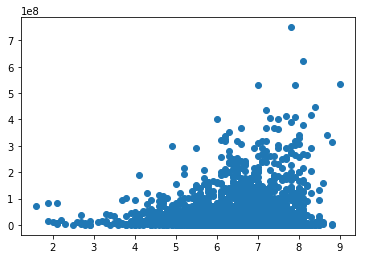

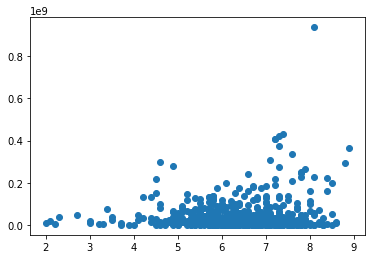

In [160]:
trainingX
plt.scatter(trainingX, trainingBO)
plt.show()

plt.scatter(trainingX, trainingBO)
plt.show()

In [153]:
regr = linear_model.LinearRegression()
res = regr.fit(trainingX, trainingBO)
print(regr.score(trainingX, trainingBO))
print(regr.score(testingX, testingBO))
yHat = regr.predict(testingX)
#conmat = sk.metrics.confusion_matrix(testingDecade, yHat)
#yHat = yHat - (yHat % 10) + 10
#print(min(yHat))
#print(max(yHat))
r2 = r2_score(testingBO, yHat)
explainedVar = explained_variance_score(testingBO, yHat)
print(explainedVar)
print(r2)
#testingBO = testingBO.as_matrix()
#conmat = sk.metrics.confusion_matrix(testingBO, yHat)

#plt.figure()
#plot_confusion_matrix(conmat, classes=set(testingBO), normalize=True,
#                      title='Confusion Matrix')

#plt.show()

0.0168213711894
0.0132673327433
0.0133293718097
0.0132673327433


In [154]:
regr = linear_model.LinearRegression()
res = regr.fit(trainingX_a, trainingBO_a)
print(regr.score(testingX_a, testingBO_a))
yHat = regr.predict(testingX_a)
#conmat = sk.metrics.confusion_matrix(testingDecade, yHat)
#yHat = yHat - (yHat % 10) + 10
#print(min(yHat))
#print(max(yHat))

r2 = r2_score(testingBO_a, yHat)
explainedVar = explained_variance_score(testingBO_a, yHat)
print(explainedVar)
print(r2)
#testingBO = testingBO.as_matrix()
#conmat = sk.metrics.confusion_matrix(testingBO, yHat)

#plt.figure()
#plot_confusion_matrix(conmat, classes=set(testingBO), normalize=True,
#                      title='Confusion Matrix')

#plt.show()

0.0414575829801
0.0417337411595
0.0414575829801


In [161]:
controlX = dfControl
actorsX = dfWithActors
Yactual = dfAwards.as_matrix().tolist()

In [162]:
# partition into testing and training
trainingX, testingX, trainingBO, testingBO = train_test_split(controlX, Yactual, test_size=0.20, random_state=42)
trainingX_a, testingX_a, trainingBO_a, testingBO_a = train_test_split(actorsX, Yactual, test_size=0.20, random_state=42)

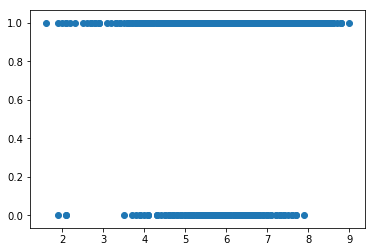

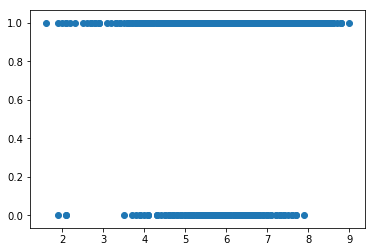

In [163]:
plt.scatter(trainingX, trainingBO)
plt.show()

plt.scatter(trainingX, trainingBO)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.910028889806
0.905940594059
Normalized confusion matrix
[[ 0.  1.]
 [ 0.  1.]]


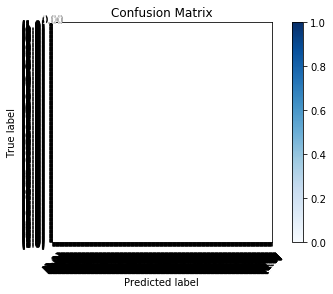

In [175]:
regr = linear_model.LogisticRegression()
res = regr.fit(trainingX, trainingBO)
print(regr.score(trainingX, trainingBO))
print(regr.score(testingX, testingBO))
yHat = regr.predict(testingX)
conmat = sk.metrics.confusion_matrix(testingBO, yHat)
#yHat = yHat - (yHat % 10) + 10
#print(min(yHat))
#print(max(yHat))

#testingBO = testingBO.as_matrix()
#conmat = sk.metrics.confusion_matrix(testingBO, yHat)

plt.figure()
plot_confusion_matrix(conmat, classes=testingBO, normalize=True,
                      title='Confusion Matrix')

plt.show()

In [170]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.90099009901
Normalized confusion matrix
[[ 0.          1.        ]
 [ 0.00546448  0.99453552]]


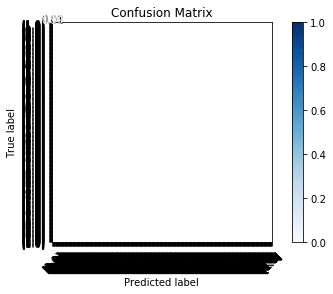

In [173]:
regr = linear_model.LogisticRegression()
res = regr.fit(trainingX_a, trainingBO_a)
print(regr.score(testingX_a, testingBO_a))
yHat = regr.predict(testingX_a)
conmat = sk.metrics.confusion_matrix(testingBO_a, yHat)
#yHat = yHat - (yHat % 10) + 10
#print(min(yHat))
#print(max(yHat))


#testingBO = testingBO.as_matrix()
#conmat = sk.metrics.confusion_matrix(testingBO, yHat)

plt.figure()
plot_confusion_matrix(conmat, classes=testingBO_a, normalize=True,
                      title='Confusion Matrix')

plt.show()